# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

Imports and set magics:

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

In [15]:
# a. load
df_confirmed = pd.read_csv("time_series_covid19_confirmed_global.csv")
df_deaths = pd.read_csv("time_series_covid19_deaths_global.csv")
df_recovered = pd.read_csv("time_series_covid19_recovered_global.csv")

dfs = [df_confirmed, df_deaths, df_recovered]

# b. drop columns
drop_these = ['Lat', 'Long', 'Province/State']
for df in dfs:
    df.drop(drop_these, axis=1, inplace=True)
    
# c. group by country
df_confirmed = df_confirmed.groupby('Country/Region').sum()
df_deaths = df_deaths.groupby('Country/Region').sum()
df_recovered = df_recovered.groupby('Country/Region').sum()


The datasets now look like this:

In [16]:
df_confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,21,22,22,22,24,24,40,40,74,84
Albania,0,0,0,0,0,0,0,0,0,0,...,51,55,59,64,70,76,89,104,123,146
Algeria,0,0,0,0,0,0,0,0,0,0,...,54,60,74,87,90,139,201,230,264,302
Andorra,0,0,0,0,0,0,0,0,0,0,...,2,39,39,53,75,88,113,133,164,188
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,2,3,3,3


In [17]:
df_deaths.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,2
Albania,0,0,0,0,0,0,0,0,0,0,...,1,1,2,2,2,2,2,4,5,5
Algeria,0,0,0,0,0,0,0,0,0,0,...,4,4,7,9,11,15,17,17,19,21
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_recovered.head()

,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,...,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2,10
Algeria,0,0,0,0,0,0,0,0,0,0,...,12,12,12,12,32,32,32,65,65,24
Andorra,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Convert to long format**

In [19]:
deaths_long = pd.DataFrame(df_deaths.unstack())
deaths_long.reset_index(inplace=True)
deaths_long.rename(columns = {'level_0':'date'}, inplace=True)
deaths_long.rename(columns = {'Unnamed':'deaths', 0:'deaths'}, inplace=True)
deaths_long = pd.melt(deaths_long,id_vars = ('Country/Region', 'date'), value_vars = 'deaths')

In [20]:
recovered_long = pd.DataFrame(df_recovered.unstack())
recovered_long.reset_index(inplace=True)
recovered_long.rename(columns = {'level_0':'date'}, inplace=True)
recovered_long.rename(columns = {'Unnamed':'recovered', 0:'recovered'}, inplace=True)
recovered_long = pd.melt(recovered_long,id_vars = ('Country/Region', 'date'), value_vars = 'recovered')

In [21]:
confirmed_long = pd.DataFrame(df_confirmed.unstack())
confirmed_long.reset_index(inplace=True)
confirmed_long.rename(columns = {'level_0':'date'}, inplace=True)
confirmed_long.rename(columns = {'Unnamed':'confirmed', 0:'confirmed'}, inplace=True)
confirmed_long = pd.melt(confirmed_long,id_vars = ('Country/Region', 'date'), value_vars = 'confirmed')

In [36]:
confirmed_long.rename(columns = {'value':'confirmed'}, inplace=True)
deaths_long.rename(columns = {'value':'deaths'}, inplace=True)
recovered_long.rename(columns = {'value':'recovered'}, inplace=True)

In [37]:
# d. set country/region as column, not index
df_confirmed.reset_index(inplace=True)
df_deaths.reset_index(inplace=True)
df_recovered.reset_index(inplace=True)


# Explore data set

In [38]:
def plot_conf_deaths_rec(df_confirmed,df_deaths,df_recovered,dataset,country_region): 
    
    if dataset == 'Confirmed':
        df = df_confirmed
        y = 'confirmed'
    elif dataset == 'Deaths':
        df = df_deaths
        y = 'deaths'
    else:
        df = df_recovered
        y = 'recovered'
    
    I = df['Country/Region'] == country_region
    ax = df.loc[I,:].plot(x='date', y=y, style='-o')

In [39]:
widgets.interact(plot_conf_deaths_rec, 
    
    df_confirmed = widgets.fixed(confirmed_long),
    df_deaths = widgets.fixed(deaths_long),
    df_recovered = widgets.fixed(recovered_long),
    dataset = widgets.Dropdown(description='Dataset', 
                               options=['Confirmed','Deaths','Recovered']),
    country_region = widgets.Dropdown(description='Country/Region', 
                                    options=confirmed_long['Country/Region'].unique())
                 
); 

interactive(children=(Dropdown(description='Dataset', options=('Confirmed', 'Deaths', 'Recovered'), value='Con…

Blah blah blah, kina har mange recovered, andre lande måler ikke recovered osv.

# Read and clean data

## Employment data

**Read the employment data** in ``RAS200.xlsx`` and **clean it** removing and renaming columns:

In [58]:
# a. load
empl = pd.read_excel('RAS200.xlsx', skiprows=2)

# b. drop columns
drop_these = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']
empl.drop(drop_these, axis=1, inplace=True)

# c. rename columns
empl.rename(columns = {'Unnamed: 4':'municipality'}, inplace=True)

The dataset now looks like this:

In [59]:
empl.head()

,municipality,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,All Denmark,76.0,72.8,72.1,71.8,71.3,71.3,71.6,72.1,72.8,73.6
1,Region Hovedstaden,75.8,73.3,72.6,72.5,72.2,72.3,72.5,73.2,73.8,74.4
2,Province Byen København,73.4,71.0,70.5,70.5,70.4,70.6,70.9,71.6,72.3,73.0
3,Copenhagen,72.5,70.0,69.7,69.6,69.4,69.7,70.0,70.8,71.5,72.2
4,Frederiksberg,75.6,73.7,72.7,72.8,73.0,73.3,73.5,74.0,74.7,75.6


**Remove all rows which are not municipalities**:

In [60]:
empl = dataproject.only_keep_municipalities(empl)
empl.head()

,municipality,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
3,Copenhagen,72.5,70.0,69.7,69.6,69.4,69.7,70.0,70.8,71.5,72.2
4,Frederiksberg,75.6,73.7,72.7,72.8,73.0,73.3,73.5,74.0,74.7,75.6
5,Dragør,80.5,78.8,78.5,78.5,78.7,78.7,78.9,78.6,79.2,80.4
6,Tårnby,79.0,76.3,75.4,75.8,75.4,75.8,75.7,76.5,77.4,77.6
8,Albertslund,73.1,69.2,67.5,67.4,66.5,67.0,67.4,68.7,68.8,70.2


**Convert the dataset to long format**:

In [61]:
# a. rename year columns
mydict = {str(i):f'employment{i}' for i in range(2008,2018)}
empl.rename(columns = mydict, inplace=True)

# b. convert to long
empl_long = pd.wide_to_long(empl, stubnames='employment', i='municipality', j='year').reset_index()

# c. show
empl_long.head()

,municipality,year,employment
0,Copenhagen,2008,72.5
1,Frederiksberg,2008,75.6
2,Dragør,2008,80.5
3,Tårnby,2008,79.0
4,Albertslund,2008,73.1


## Income data

**Read the income data** in ``INDKP101.xlsx`` and **clean it**:

In [62]:
# a. load
inc = pd.read_excel('INDKP101.xlsx', skiprows=2)

# b. drop and rename columns
inc.drop([f'Unnamed: {i}' for i in range(3)], axis=1, inplace=True)
inc.rename(columns = {'Unnamed: 3':'municipality'}, inplace=True)

# c. drop rows with missing
inc.dropna(inplace=True)

# d. remove non-municipalities
inc = dataproject.only_keep_municipalities(inc)

# e. convert to long
inc.rename(columns = {str(i):f'income{i}' for i in range(1986,2018)}, inplace=True)
inc_long = pd.wide_to_long(inc, stubnames='income', i='municipality', j='year').reset_index()

# f. show
inc_long.head(5)

,municipality,year,income
0,Copenhagen,1987,75356
1,Frederiksberg,1987,85428
2,Dragør,1987,97966
3,Tårnby,1987,87598
4,Albertslund,1987,83540


> **Note:** The function ``dataproject.only_keep_municipalities()`` is used on both the employment and the income datasets.

## Explore data set

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, the employment and income level in each municipality

The **static plot** is:

In [63]:
def plot_empl_inc(empl,inc,dataset,municipality): 
    
    if dataset == 'Employment':
        df = empl
        y = 'employment'
    else:
        df = inc
        y = 'income'
    
    I = df['municipality'] == municipality
    ax = df.loc[I,:].plot(x='year', y=y, style='-o')

The **interactive plot** is:

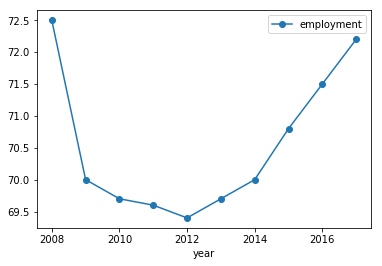

In [64]:
widgets.interact(plot_empl_inc, 
    
    empl = widgets.fixed(empl_long),
    inc = widgets.fixed(inc_long),
    dataset = widgets.Dropdown(description='Dataset', 
                               options=['Employment','Income']),
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=empl_long.municipality.unique())
                 
); 

ADD SOMETHING HERE IF THE READER SHOULD KNOW THAT E.G. SOME MUNICIPALITY IS SPECIAL.

# Merge data sets

We now create a data set with **municpalities which are in both of our data sets**. We can illustrate this **merge** as:

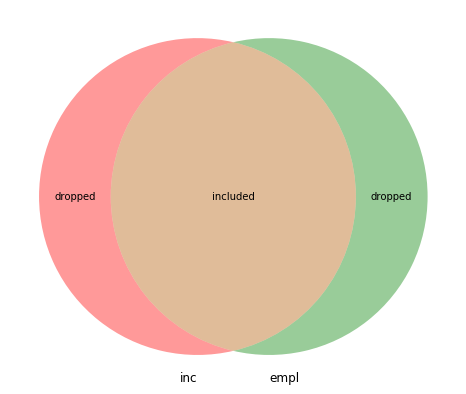

In [10]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('inc', 'empl'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

In [11]:
merged = pd.merge(empl_long, inc_long, how='inner',on=['municipality','year'])

print(f'Number of municipalities = {len(merged.municipality.unique())}')
print(f'Number of years          = {len(merged.year.unique())}')

Number of municipalities = 98
Number of years          = 10


# Analysis

To get a quick overview of the data, we show some **summary statistics by year**:

In [12]:
merged.groupby('year').agg(['mean','std']).round(2)

employment           income          
           mean   std       mean       std
year                                      
2008      76.77  3.47  178055.96  23177.06
2009      73.51  3.53  180520.09  20874.01
2010      72.85  3.60  196646.87  27451.01
2011      72.64  3.68  200888.37  29387.03
2012      72.04  3.82  206097.96  30727.89
2013      72.12  3.71  211694.96  32507.07
2014      72.46  3.67  215872.63  34819.29
2015      72.85  3.66  221536.18  38417.81
2016      73.63  3.54  224775.65  38432.09
2017      74.40  3.51  231230.17  39107.17

ADD FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.